# **2.1**

Principle Component Analysis

In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from tensorflow.keras.datasets import mnist
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.utils import to_categorical

# Load and preprocess the MNIST dataset
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0
x_train = x_train.reshape(-1, 28 * 28)
x_test = x_test.reshape(-1, 28 * 28)
y_train, y_test = to_categorical(y_train), to_categorical(y_test)

In [ ]:
# Define the DNN model
def create_dnn_model():
    model = Sequential([
        Dense(100, activation='relu', input_shape=(784,), kernel_initializer='random_normal'),
        Dense(200, activation='relu', kernel_initializer='random_normal'),
        Dense(200, activation='relu', kernel_initializer='random_normal'),
        Dense(200, activation='relu', kernel_initializer='random_normal'),
        Dense(200, activation='relu', kernel_initializer='random_normal'),
        Dense(200, activation='relu', kernel_initializer='random_normal'),
        Dense(100, activation='relu', kernel_initializer='random_normal'),
        Dense(10, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

class WeightsCollector(tf.keras.callbacks.Callback):
    def __init__(self, interval=3):
        super(WeightsCollector, self).__init__()
        self.interval = interval
        self.weights_history = []
        self.accuracy_history = []

    def on_epoch_end(self, epoch, logs=None):
        if (epoch + 1) % self.interval == 0:
            # Collect weights from the first Dense layer
            layer_weights = self.model.layers[0].get_weights()[0]
            self.weights_history.append(layer_weights.flatten())
            self.accuracy_history.append(logs['accuracy'])

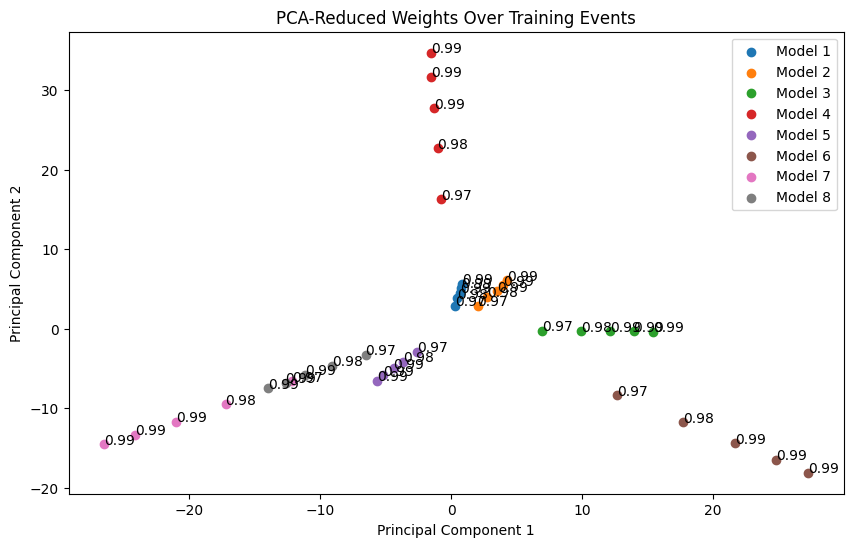

In [ ]:
# Train the model and collect weights
num_training_events = 8
all_weights = []
all_accuracies = []

for i in range(num_training_events):
    model = create_dnn_model()
    weights_collector = WeightsCollector(interval=3)
    history = model.fit(x_train, y_train, epochs=15, verbose=0, validation_data=(x_test, y_test), callbacks=[weights_collector])
    all_weights.extend(weights_collector.weights_history)
    all_accuracies.extend(weights_collector.accuracy_history)

all_weights_np = np.array(all_weights)

# Apply PCA to reduce the dimensionality
pca = PCA(n_components=2)
reduced_weights = pca.fit_transform(all_weights_np)

plt.figure(figsize=(10, 6))
for i in range(num_training_events):
    indices = range(i*5, (i+1)*5)
    plt.scatter(reduced_weights[indices, 0], reduced_weights[indices, 1], label=f'Model {i+1}')
    for j, txt in enumerate(np.round(all_accuracies[i*5:(i+1)*5], 2)):
        plt.annotate(txt, (reduced_weights[indices[j], 0], reduced_weights[indices[j], 1]))
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA-Reduced Weights Over Training Events')
plt.legend()
plt.show()
